# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from keras.models import Sequential, Model
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,Input
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import balanced_accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Input, Reshape, Flatten
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
tf.compat.v1.disable_eager_execution()
from keras.utils import plot_model

# Loading Dataset and spilting into Training dataset, Testing dataset and Validation dataset

In [2]:
df = pd.read_csv("IDS_2018/combined_DF.csv")

In [3]:
df.shape

(1643244, 6)

In [4]:
df["Label"].value_counts()

Label
Benign    957232
DDOS      686012
Name: count, dtype: int64

In [5]:
class_counts = df["Label"].value_counts()

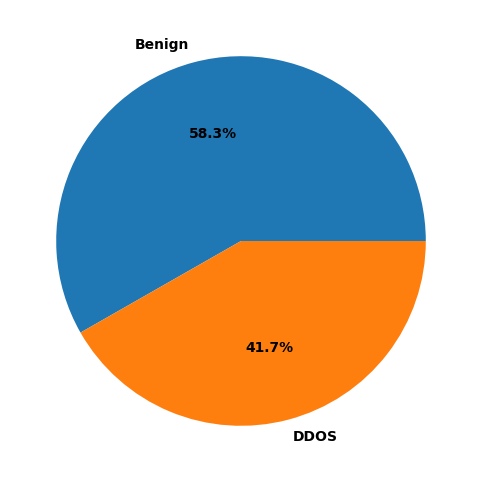

In [6]:
plt.figure(figsize=(10, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.show()

In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
X = df[list(df.columns)]
y = df.loc[:, df.columns == "Label"]
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.9, random_state=1)

In [299]:
# X_train.to_csv('X_train.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# X_val.to_csv('X_val.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

In [8]:
X_train = pd.read_csv('Thesis/X_train.csv')
y_train = pd.read_csv('Thesis/y_train.csv')
X_val = pd.read_csv('Thesis/X_val.csv')
X_test = pd.read_csv('Thesis/X_test.csv')
y_val = pd.read_csv('Thesis/y_val.csv')
y_test = pd.read_csv('Thesis/y_test.csv')

In [9]:
scaler = MinMaxScaler()

In [10]:
cols_X = X_train.select_dtypes(include=['float64','int64']).columns
cols_test_X = X_test.select_dtypes(include=['float64','int64']).columns
sc_train_X = scaler.fit_transform(X_train.select_dtypes(include=['float64','int64']))
sc_test_X = scaler.fit_transform(X_test.select_dtypes(include=['float64','int64']))
sc_traindf_X = pd.DataFrame(sc_train_X, columns = cols_X)
sc_testdf_X = pd.DataFrame(sc_test_X, columns = cols_test_X)

cols_x_val=X_val.select_dtypes(include=['float64','int64']).columns
sc_val_X=scaler.fit_transform(X_val.select_dtypes(include=['float64','int64']))
sc_valdf_X=pd.DataFrame(sc_val_X, columns = cols_x_val)

In [12]:
sc_traindf_X.head()

,Flow Duration,Bwd Pkt Len Std,Pkt Size Avg,Flow IAT Std
0,0.000002,0.000000,0.000000,0.000000
1,0.922048,0.429952,0.169415,0.039595
2,0.000010,0.000000,0.053620,0.000000
3,0.000010,0.000000,0.044740,0.000000
4,0.000088,0.000000,0.000000,0.000000


In [13]:
sc_testdf_X.head()

,Flow Duration,Bwd Pkt Len Std,Pkt Size Avg,Flow IAT Std
0,0.000180,0.0,0.0,0.0
1,0.000104,0.0,0.0,0.0
2,0.000008,0.0,0.0,0.0
3,0.000247,0.0,0.0,0.0
4,0.000125,0.0,0.0,0.0


In [14]:
sc_valdf_X.head()

,Flow Duration,Bwd Pkt Len Std,Pkt Size Avg,Flow IAT Std
0,0.000023,0.000000,0.052844,0.000000
1,0.000056,0.000000,0.000000,0.000000
2,0.000125,0.000000,0.000000,0.000000
3,0.979959,0.569224,0.118319,0.167029
4,0.000011,0.242450,0.123354,0.000004


In [12]:
labelencoder = LabelEncoder()
y_train_encoded = labelencoder.fit_transform(y_train)
y_train_encoded

C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 0, 0, 0])

In [13]:
y_test_encoded = labelencoder.fit_transform(y_test)
y_test_encoded

array([1, 1, 1, ..., 1, 0, 0])

In [14]:
y_val_encoded = labelencoder.fit_transform(y_val)
y_val_encoded

array([0, 1, 1, ..., 0, 0, 1])

# Model Training and testing. 

In [18]:
learning_rate = 0.0001#0.0001
optimizer = Adam(learning_rate=learning_rate)

In [19]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, activation=tf.nn.relu,input_shape = (4,)),
#   tf.keras.layers.Dense(512, activation=tf.nn.relu),
#   tf.keras.layers.Dropout(0.05),#.05 
#   tf.keras.layers.Dense(256, activation=tf.nn.relu),
#   tf.keras.layers.Dropout(0.05),#.05
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.05),#.05
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [20]:
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [21]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [80]:
# model.save("perfectmodel.h5")

In [23]:
history = model.fit(sc_traindf_X, y_train_encoded,batch_size=700, epochs=50,verbose=1,validation_data=(sc_valdf_X, y_val_encoded),callbacks=[early_stop])

Train on 1314595 samples, validate on 32864 samples
Epoch 1/50
1314595/1314595 [==============================] - ETA: 0s - loss: 0.5538 - accuracy: 0.6507

C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1314595/1314595 [==============================] - 19s 14us/sample - loss: 0.5538 - accuracy: 0.6507 - val_loss: 0.3964 - val_accuracy: 0.8100
Epoch 2/50
1314595/1314595 [==============================] - 18s 14us/sample - loss: 0.2413 - accuracy: 0.9079 - val_loss: 0.3042 - val_accuracy: 0.8800
Epoch 3/50
1314595/1314595 [==============================] - 18s 14us/sample - loss: 0.2081 - accuracy: 0.9262 - val_loss: 0.3097 - val_accuracy: 0.8829
Epoch 4/50
1314595/1314595 [==============================] - 19s 15us/sample - loss: 0.2059 - accuracy: 0.9267 - val_loss: 0.3099 - val_accuracy: 0.8843
Epoch 5/50
1314595/1314595 [==============================] - 20s 15us/sample - loss: 0.2043 - accuracy: 0.9269 - val_loss: 0.3019 - val_accuracy: 0.8867
Epoch 6/50
1314595/1314595 [==============================] - 19s 14us/sample - loss: 0.2029 - accuracy: 0.9269 - val_loss: 0.2954 - val_accuracy: 0.8883
Epoch 7/50
1314595/1314595 [==============================] - 19s 14us/sample - loss: 0

In [298]:
import pickle

# Assuming you have trained your model and have the 'history' object

# Save the history to a file
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

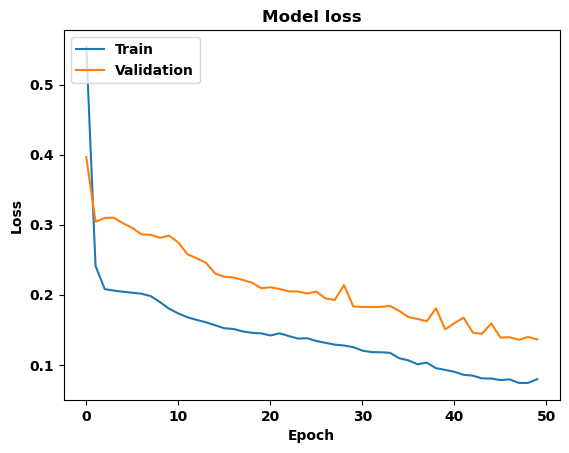

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

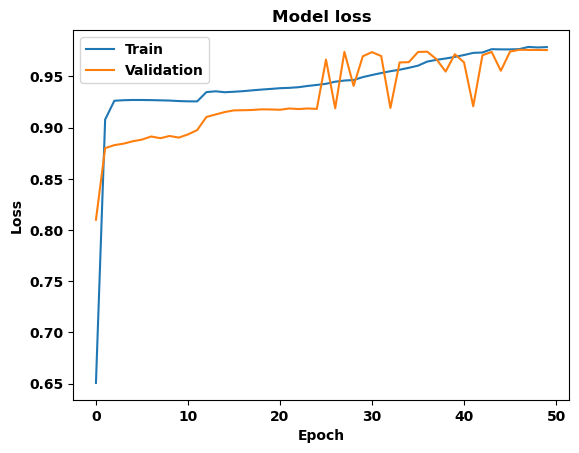

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [4]:
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod,BasicIterativeMethod, ProjectedGradientDescent

C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [5]:
Classifier = KerasClassifier( model=modeld_,use_logits=False)

In [15]:
modeld_.evaluate(sc_testdf_X, y_test_encoded)

C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[0.18691685192248805, 0.9648934]

In [16]:
sc_testdf_X_np = sc_testdf_X.values

In [17]:
y_pred = Classifier.predict(sc_testdf_X_np)

C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [18]:
y_pred = np.round(y_pred)

In [19]:
y_pred_1d = np.squeeze(y_pred).astype(int)

In [20]:
precision = precision_score(y_test_encoded, y_pred_1d,average='weighted')
recall = recall_score(y_test_encoded, y_pred_1d,average='weighted')

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9674334356358564
Recall: 0.9648934192065183


In [21]:
balanced_acc = balanced_accuracy_score(y_test_encoded, y_pred_1d)
print("Balanced Accuracy:", balanced_acc)

Balanced Accuracy: 0.9696548706397712


In [22]:
print(classification_report(y_test_encoded, y_pred_1d))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    172373
           1       0.92      1.00      0.96    123412

    accuracy                           0.96    295785
   macro avg       0.96      0.97      0.96    295785
weighted avg       0.97      0.96      0.97    295785



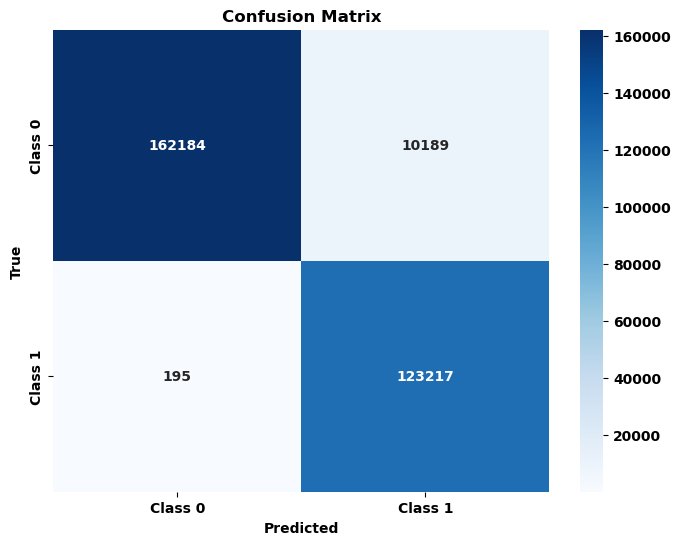

In [23]:
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_encoded, y_pred_1d)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Attack generationg
## Generating attack packets using ART libraries
## Testing the generated attack packets

In [333]:
attack_pgd = ProjectedGradientDescent(estimator=classifier,norm=np.inf, batch_size=300, verbose=False, num_random_init=1, eps=1, eps_step=0.0001, max_iter=40) #1,.0001

In [144]:
X_test_adv =attack_pgd.generate(sc_testdf_X_np)

In [145]:
adversarial_samples = pd.DataFrame(X_test_adv, columns=[' Flow Duration', ' Bwd Packet Length Std', ' Average Packet Size', ' Flow IAT Std'])

In [146]:
adversarial_samples.describe()

,Flow Duration,Bwd Packet Length Std,Average Packet Size,Flow IAT Std
count,295785.000000,295785.000000,295785.000000,295785.000000
mean,0.044077,0.173270,0.055605,0.009399
std,0.606276,0.621226,0.581051,0.578774
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.472877,-0.330217,-0.445708,-0.491816
50%,0.046300,0.176116,0.055903,0.011000
75%,0.548689,0.672535,0.555917,0.509412
max,2.000000,1.952025,1.816312,1.842016


In [147]:
sc_testdf_X.describe()

,Flow Duration,Bwd Pkt Len Std,Pkt Size Avg,Flow IAT Std
count,295785.000000,295785.000000,295785.000000,295785.000000
mean,0.043018,0.176420,0.052728,0.004776
std,0.176584,0.229302,0.059514,0.026732
min,0.000000,0.000000,0.000000,0.000000
25%,0.000011,0.000000,0.000000,0.000000
50%,0.000047,0.000000,0.043094,0.000001
75%,0.000183,0.282415,0.099967,0.000055
max,1.000000,1.000000,1.000000,1.000000


In [25]:
X_test_adv = np.load('Thesis\PGD_samples.npy')

In [27]:
modeld_.evaluate(X_test_adv, y_test_encoded)

[5923.2950921595475, 0.5630238]

In [149]:
# attacker = FastGradientMethod(classifier, eps=.2)

In [150]:
# x_test_adv = attacker.generate(sc_testdf_X_np)

In [151]:
# model.evaluate(x_test_adv, y_test_encoded)

In [29]:
y_adv = Classifier.predict(X_test_adv)

In [30]:
y_adv = np.round(y_adv)

In [31]:
y_adv = np.squeeze(y_adv).astype(int)

In [32]:
precision = precision_score(y_test_encoded, y_adv)
recall = recall_score(y_test_encoded, y_adv)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.4282977626053
Recall: 0.14130716623991185


In [33]:
print(classification_report(y_test_encoded, y_adv))

              precision    recall  f1-score   support

           0       0.58      0.86      0.70    172373
           1       0.43      0.14      0.21    123412

    accuracy                           0.56    295785
   macro avg       0.51      0.50      0.46    295785
weighted avg       0.52      0.56      0.50    295785



# Adversarial training on model.

In [300]:
from art.defences.trainer import AdversarialTrainer

In [301]:
trainer = AdversarialTrainer(classifier, attack_pgd, ratio=.7)

In [302]:
trainer.fit(sc_traindf_X.values, y_train_encoded,nb_epochs=20, batch_size=700)

Adversarial training epochs: 100%|████████████████████████████████████████████████| 20/20 [10:13:59<00:00, 1841.97s/it]


In [75]:
# file_name = 'sc_traindf_X.npy'

In [76]:
# np.save(file_name, sc_traindf_X.values)

In [77]:
# file_name = 'y_train_encoded.npy'

In [78]:
# np.save(file_name, y_train_encoded)

In [250]:
ddos_samples=sc_ddos_samples[sc_ddos_samples['Label']=='DDOS']

In [251]:
X_dd =ddos_samples.drop('Label', axis=1)
y_dd = ddos_samples.loc[:, ddos_samples.columns == "Label"]

In [252]:
X_dd

,Flow Duration,Bwd Pkt Len Std,Pkt Size Avg,Flow IAT Std
2,0.000114,0.455962,0.097929,0.000047
5,0.000014,0.000000,0.000000,0.000000
6,0.000070,0.455962,0.101924,0.000035
7,0.000009,0.000000,0.000000,0.000000
9,0.000026,0.000000,0.000000,0.000000
...,...,...,...,...
1643236,0.000076,0.000000,0.000000,0.000000
1643237,0.000083,0.000000,0.000000,0.000000
1643238,0.000224,0.000000,0.000000,0.000000
1643240,0.000018,0.000000,0.000000,0.000000


In [238]:
cols_ddos_samples=X_dd.select_dtypes(include=['float64','int64']).columns
sc_ddos_samples=scaler.fit_transform(ddos_samples.select_dtypes(include=['float64','int64']))
sc_ddos_samples=pd.DataFrame(sc_ddos_samples, columns = cols_ddos_samples)

In [244]:
sc_ddos_samples

,Flow Duration,Bwd Pkt Len Std,Pkt Size Avg,Flow IAT Std,Label
0,0.021554,0.389056,0.101464,0.002876,Benign
1,0.000010,0.235172,0.104044,0.000003,Benign
2,0.000114,0.455962,0.097929,0.000047,DDOS
3,0.000007,0.237978,0.052919,0.000001,Benign
4,0.000053,0.217931,0.102006,0.000025,Benign
...,...,...,...,...,...
1643239,0.000008,0.000000,0.044806,0.000000,Benign
1643240,0.000018,0.000000,0.000000,0.000000,DDOS
1643241,0.000011,0.216552,0.101843,0.000003,Benign
1643242,0.000003,0.000000,0.076769,0.000000,Benign


In [243]:
sc_ddos_samples['Label']=y_dd

In [260]:
def generate_array_with_n_ones(n):
    # Create an array of ones
    arr = np.ones(n, dtype=int)
    return arr

# Example usage
array_size =100000      # Size of the array (number of 1s)
result_array = generate_array_with_n_ones(array_size)
print(result_array) 

[1 1 1 ... 1 1 1]


# Training and Generating adversarial samples using GAN!!

In [342]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# Define the generator network
def build_generator(noise_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(4, activation='sigmoid'))  # Adjust the output dimensions based on your dataset
    return model

# Define the discriminator network
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1))
    return model

# Build and compile the generator and discriminator
noise_dim = 54 # Adjust the noise dimension as needed
generator = build_generator(noise_dim)
discriminator = build_discriminator(4)  # Assuming 4 input features, adjust as needed

# Compile the discriminator
discriminator.compile(optimizer=RMSprop(learning_rate=0.01), loss=wasserstein_loss)

# Freeze the discriminator during generator training
discriminator.trainable = False

# Build the WGAN model
z = Input(shape=(noise_dim,))
generated_sample = generator(z)
validity = discriminator(generated_sample)

wgan = Model(z, validity)
wgan.compile(optimizer=RMSprop(learning_rate=0.01), loss=wasserstein_loss)

# Train the WGAN
# Implement the training logic for the WGAN
# You'll need to train the generator and discriminator in an alternating fashion
# For simplicity, let's assume a function 'train_wgan()' to handle this
# The train_wgan() function should return the trained generator

# Train the WGAN
import pandas as pd
import numpy as np


def train_wgan(generator, discriminator, wgan, data, noise_dim, epochs, batch_size):
    # Convert data to a numpy array if it's a DataFrame
    if isinstance(data, pd.DataFrame):
        data = data.values
    d_losses_real = []
    d_losses_fake = []
    g_losses = []
    for epoch in range(epochs):
        
        
        for _ in range(5):  # Train the discriminator more times than the generator
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_samples = data[idx]

            noise = np.random.randn(batch_size, noise_dim)
            fake_samples = generator.predict(noise)

            # Compute Wasserstein loss for the discriminator
            disc_loss_real = discriminator.train_on_batch(real_samples, -np.ones((batch_size, 1)))
            disc_loss_fake = discriminator.train_on_batch(fake_samples, np.ones((batch_size, 1)))
            
        
        noise = np.random.randn(batch_size, noise_dim)
        gen_loss = wgan.train_on_batch(noise, -np.ones((batch_size, 1)))
        g_losses.append(gen_loss)
        d_losses_real.append(disc_loss_real)
        d_losses_fake.append(disc_loss_fake)
        
        # Print progress
        print(f"Epoch {epoch}, D Loss Real: {np.mean(d_losses_real)}, D Loss Fake: {np.mean(d_losses_fake)}, G Loss: {np.mean(g_losses)}")
    
    return generator


# Example usage with a DataFrame (assuming _traindf_X is a DataFrame)
trained_generator = train_wgan(generator, discriminator, wgan, X_dd, noise_dim, epochs=1000, batch_size=64)

C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch 0, D Loss Real: -1.2414367198944092, D Loss Fake: -12.763758659362793, G Loss: 41.12755584716797
Epoch 1, D Loss Real: -88.32161712646484, D Loss Fake: -358.0046081542969, G Loss: 552.6759643554688
Epoch 2, D Loss Real: -905.5685424804688, D Loss Fake: -2266.280029296875, G Loss: 2381.578857421875
Epoch 3, D Loss Real: -2655.91845703125, D Loss Fake: -4818.37548828125, G Loss: 5728.94189453125
Epoch 4, D Loss Real: -5180.43701171875, D Loss Fake: -9169.291015625, G Loss: 10912.900390625
Epoch 5, D Loss Real: -8375.39453125, D Loss Fake: -11578.71875, G Loss: 16339.7587890625
Epoch 6, D Loss Real: -12381.400390625, D Loss Fake: -17574.009765625, G Loss: 24184.78515625
Epoch 7, D Loss Real: -17026.025390625, D Loss Fake: -28991.40625, G Loss: 31586.345703125
Epoch 8, D Loss Real: -21473.966796875, D Loss Fake: -37016.90625, G Loss: 38540.578125
Epoch 9, D Loss Real: -26687.443359375, D Loss Fake: -50865.13671875, G Loss: 53556.375
Epoch 10, D Loss Real: -33935.81640625, D Loss Fake

Epoch 99, D Loss Real: -1028896.1875, D Loss Fake: 56484.5, G Loss: -121731.828125
Epoch 100, D Loss Real: -1042172.9375, D Loss Fake: 71751.7734375, G Loss: -134936.59375
Epoch 101, D Loss Real: -1053811.75, D Loss Fake: 86984.546875, G Loss: -148147.515625
Epoch 102, D Loss Real: -1071877.5, D Loss Fake: 102487.671875, G Loss: -161643.4375
Epoch 103, D Loss Real: -1086900.375, D Loss Fake: 118181.546875, G Loss: -175503.484375
Epoch 104, D Loss Real: -1102732.0, D Loss Fake: 134109.96875, G Loss: -189464.875
Epoch 105, D Loss Real: -1119102.0, D Loss Fake: 150099.71875, G Loss: -203829.65625
Epoch 106, D Loss Real: -1137234.125, D Loss Fake: 167359.078125, G Loss: -218600.96875
Epoch 107, D Loss Real: -1156908.75, D Loss Fake: 190061.4375, G Loss: -235697.203125
Epoch 108, D Loss Real: -1181565.875, D Loss Fake: 147722.40625, G Loss: -263383.375
Epoch 109, D Loss Real: -1202348.75, D Loss Fake: 74757.0625, G Loss: -288993.75
Epoch 110, D Loss Real: -1219280.75, D Loss Fake: -14501.10

Epoch 195, D Loss Real: -786975.6875, D Loss Fake: -330108.28125, G Loss: 89407.234375
Epoch 196, D Loss Real: -787172.5625, D Loss Fake: -322803.21875, G Loss: 83285.6640625
Epoch 197, D Loss Real: -788357.0625, D Loss Fake: -312282.875, G Loss: 77124.3203125
Epoch 198, D Loss Real: -789971.4375, D Loss Fake: -304973.46875, G Loss: 70872.0234375
Epoch 199, D Loss Real: -789955.8125, D Loss Fake: -296878.90625, G Loss: 64519.3984375
Epoch 200, D Loss Real: -790481.6875, D Loss Fake: -286627.53125, G Loss: 59404.66796875
Epoch 201, D Loss Real: -790832.0, D Loss Fake: -280309.375, G Loss: 53528.98046875
Epoch 202, D Loss Real: -790496.5625, D Loss Fake: -272764.40625, G Loss: 48573.26953125
Epoch 203, D Loss Real: -789526.5, D Loss Fake: -265085.4375, G Loss: 43724.4609375
Epoch 204, D Loss Real: -788295.625, D Loss Fake: -259364.921875, G Loss: 39256.19140625
Epoch 205, D Loss Real: -787216.125, D Loss Fake: -254126.40625, G Loss: 35019.4375
Epoch 206, D Loss Real: -785580.6875, D Loss

Epoch 290, D Loss Real: -836945.625, D Loss Fake: 26507.765625, G Loss: -173330.59375
Epoch 291, D Loss Real: -838654.5, D Loss Fake: 29888.08203125, G Loss: -176077.296875
Epoch 292, D Loss Real: -840232.1875, D Loss Fake: 33244.33984375, G Loss: -178902.109375
Epoch 293, D Loss Real: -842209.0625, D Loss Fake: 36673.796875, G Loss: -181709.40625
Epoch 294, D Loss Real: -845498.9375, D Loss Fake: 40239.16015625, G Loss: -184672.421875
Epoch 295, D Loss Real: -848946.375, D Loss Fake: 43916.91796875, G Loss: -187617.015625
Epoch 296, D Loss Real: -853033.1875, D Loss Fake: 47379.6640625, G Loss: -190674.25
Epoch 297, D Loss Real: -856406.9375, D Loss Fake: 51163.0078125, G Loss: -193831.640625
Epoch 298, D Loss Real: -859819.875, D Loss Fake: 55271.33203125, G Loss: -197449.1875
Epoch 299, D Loss Real: -863240.9375, D Loss Fake: 60015.78515625, G Loss: -201295.90625
Epoch 300, D Loss Real: -867412.4375, D Loss Fake: 66874.1015625, G Loss: -205486.921875
Epoch 301, D Loss Real: -871109.

Epoch 387, D Loss Real: -1120001.125, D Loss Fake: 222161.4375, G Loss: -266646.5
Epoch 388, D Loss Real: -1125006.5, D Loss Fake: 201098.28125, G Loss: -263739.21875
Epoch 389, D Loss Real: -1126616.0, D Loss Fake: 183715.0, G Loss: -259818.375
Epoch 390, D Loss Real: -1129433.625, D Loss Fake: 179857.515625, G Loss: -254838.34375
Epoch 391, D Loss Real: -1133478.0, D Loss Fake: 179341.59375, G Loss: -250704.3125
Epoch 392, D Loss Real: -1136927.125, D Loss Fake: 175779.34375, G Loss: -246498.359375
Epoch 393, D Loss Real: -1139602.875, D Loss Fake: 174003.609375, G Loss: -246352.765625
Epoch 394, D Loss Real: -1140569.625, D Loss Fake: 178984.703125, G Loss: -251963.578125
Epoch 395, D Loss Real: -1140166.0, D Loss Fake: 188649.421875, G Loss: -264338.3125
Epoch 396, D Loss Real: -1147067.625, D Loss Fake: 196839.90625, G Loss: -271192.03125
Epoch 397, D Loss Real: -1151531.875, D Loss Fake: 198506.65625, G Loss: -280392.875
Epoch 398, D Loss Real: -1147257.875, D Loss Fake: 180219.0

Epoch 483, D Loss Real: -809168.6875, D Loss Fake: -179834.25, G Loss: 165382.15625
Epoch 484, D Loss Real: -792637.375, D Loss Fake: -221104.359375, G Loss: 210639.875
Epoch 485, D Loss Real: -775707.125, D Loss Fake: -270622.34375, G Loss: 242116.34375
Epoch 486, D Loss Real: -757642.0, D Loss Fake: -298926.28125, G Loss: 265522.53125
Epoch 487, D Loss Real: -735554.75, D Loss Fake: -345310.0625, G Loss: 332299.9375
Epoch 488, D Loss Real: -717316.25, D Loss Fake: -387695.21875, G Loss: 379503.90625
Epoch 489, D Loss Real: -695492.25, D Loss Fake: -432335.0, G Loss: 416076.28125
Epoch 490, D Loss Real: -668878.625, D Loss Fake: -481018.625, G Loss: 465476.3125
Epoch 491, D Loss Real: -630631.0625, D Loss Fake: -531777.5625, G Loss: 510645.96875
Epoch 492, D Loss Real: -601420.9375, D Loss Fake: -592310.8125, G Loss: 563015.6875
Epoch 493, D Loss Real: -570612.3125, D Loss Fake: -649639.25, G Loss: 622527.375
Epoch 494, D Loss Real: -542292.75, D Loss Fake: -713604.8125, G Loss: 68440

Epoch 580, D Loss Real: -364554.5, D Loss Fake: -488802.03125, G Loss: 495790.875
Epoch 581, D Loss Real: -364849.71875, D Loss Fake: -492761.5625, G Loss: 502519.46875
Epoch 582, D Loss Real: -366635.71875, D Loss Fake: -498911.21875, G Loss: 511046.875
Epoch 583, D Loss Real: -369003.34375, D Loss Fake: -507385.65625, G Loss: 521639.875
Epoch 584, D Loss Real: -381598.5625, D Loss Fake: -517598.40625, G Loss: 534203.125
Epoch 585, D Loss Real: -392245.125, D Loss Fake: -529965.25, G Loss: 549037.0625
Epoch 586, D Loss Real: -400368.75, D Loss Fake: -544949.125, G Loss: 566131.0
Epoch 587, D Loss Real: -417892.1875, D Loss Fake: -561757.5625, G Loss: 585546.8125
Epoch 588, D Loss Real: -437569.0, D Loss Fake: -582117.0625, G Loss: 607724.25
Epoch 589, D Loss Real: -489144.5, D Loss Fake: -605712.125, G Loss: 633360.125
Epoch 590, D Loss Real: -506395.40625, D Loss Fake: -631723.8125, G Loss: 661638.5625
Epoch 591, D Loss Real: -587910.0625, D Loss Fake: -661092.4375, G Loss: 693404.06

Epoch 683, D Loss Real: -14077347.0, D Loss Fake: 10065409.0, G Loss: -8015465.5
Epoch 684, D Loss Real: -14318614.0, D Loss Fake: 11932956.0, G Loss: -9488702.0
Epoch 685, D Loss Real: -14557372.0, D Loss Fake: 13650790.0, G Loss: -10939323.0
Epoch 686, D Loss Real: -14772093.0, D Loss Fake: 15140618.0, G Loss: -12308480.0
Epoch 687, D Loss Real: -14965147.0, D Loss Fake: 16426944.0, G Loss: -13556227.0
Epoch 688, D Loss Real: -15194900.0, D Loss Fake: 17703992.0, G Loss: -14807695.0
Epoch 689, D Loss Real: -15344888.0, D Loss Fake: 18918836.0, G Loss: -15959656.0
Epoch 690, D Loss Real: -15555208.0, D Loss Fake: 19933940.0, G Loss: -16932598.0
Epoch 691, D Loss Real: -15651605.0, D Loss Fake: 21175462.0, G Loss: -17917682.0
Epoch 692, D Loss Real: -15835977.0, D Loss Fake: 21950416.0, G Loss: -18820770.0
Epoch 693, D Loss Real: -15963568.0, D Loss Fake: 22665896.0, G Loss: -19605256.0
Epoch 694, D Loss Real: -16085998.0, D Loss Fake: 23471832.0, G Loss: -20284988.0
Epoch 695, D Loss 

Epoch 783, D Loss Real: -26435436.0, D Loss Fake: 35886712.0, G Loss: -32529274.0
Epoch 784, D Loss Real: -26580212.0, D Loss Fake: 35754272.0, G Loss: -32392276.0
Epoch 785, D Loss Real: -26842928.0, D Loss Fake: 35606412.0, G Loss: -32238988.0
Epoch 786, D Loss Real: -27098508.0, D Loss Fake: 35445084.0, G Loss: -32070392.0
Epoch 787, D Loss Real: -27226118.0, D Loss Fake: 35270940.0, G Loss: -31887644.0
Epoch 788, D Loss Real: -27527954.0, D Loss Fake: 35078184.0, G Loss: -31689020.0
Epoch 789, D Loss Real: -27926878.0, D Loss Fake: 34869504.0, G Loss: -31474030.0
Epoch 790, D Loss Real: -27979424.0, D Loss Fake: 34648128.0, G Loss: -31245746.0
Epoch 791, D Loss Real: -28355022.0, D Loss Fake: 34409696.0, G Loss: -30999428.0
Epoch 792, D Loss Real: -28722908.0, D Loss Fake: 34147652.0, G Loss: -30720284.0
Epoch 793, D Loss Real: -29076712.0, D Loss Fake: 33858824.0, G Loss: -30418712.0
Epoch 794, D Loss Real: -29454812.0, D Loss Fake: 33544078.0, G Loss: -30091924.0
Epoch 795, D Los

Epoch 884, D Loss Real: -40121940.0, D Loss Fake: 37011492.0, G Loss: -35276480.0
Epoch 885, D Loss Real: -40196868.0, D Loss Fake: 36328252.0, G Loss: -34751896.0
Epoch 886, D Loss Real: -40350268.0, D Loss Fake: 35781144.0, G Loss: -34612440.0
Epoch 887, D Loss Real: -40683948.0, D Loss Fake: 35657356.0, G Loss: -34440428.0
Epoch 888, D Loss Real: -40883820.0, D Loss Fake: 35620476.0, G Loss: -34378728.0
Epoch 889, D Loss Real: -41260724.0, D Loss Fake: 35580036.0, G Loss: -34212188.0
Epoch 890, D Loss Real: -41640764.0, D Loss Fake: 35125252.0, G Loss: -34015060.0
Epoch 891, D Loss Real: -41786456.0, D Loss Fake: 34887768.0, G Loss: -33976624.0
Epoch 892, D Loss Real: -42023220.0, D Loss Fake: 34895856.0, G Loss: -33889276.0
Epoch 893, D Loss Real: -42198636.0, D Loss Fake: 34505524.0, G Loss: -33509260.0
Epoch 894, D Loss Real: -42638856.0, D Loss Fake: 34443268.0, G Loss: -33378848.0
Epoch 895, D Loss Real: -43058912.0, D Loss Fake: 34378140.0, G Loss: -33296148.0
Epoch 896, D Los

Epoch 984, D Loss Real: -76932696.0, D Loss Fake: 43588552.0, G Loss: -41876448.0
Epoch 985, D Loss Real: -77046840.0, D Loss Fake: 43366436.0, G Loss: -41685896.0
Epoch 986, D Loss Real: -77145968.0, D Loss Fake: 43120696.0, G Loss: -41518932.0
Epoch 987, D Loss Real: -77218408.0, D Loss Fake: 42693520.0, G Loss: -41178544.0
Epoch 988, D Loss Real: -77316960.0, D Loss Fake: 42373876.0, G Loss: -40963508.0
Epoch 989, D Loss Real: -77456528.0, D Loss Fake: 42136000.0, G Loss: -40785568.0
Epoch 990, D Loss Real: -77529936.0, D Loss Fake: 42025456.0, G Loss: -40581004.0
Epoch 991, D Loss Real: -77582248.0, D Loss Fake: 41837656.0, G Loss: -40177492.0
Epoch 992, D Loss Real: -77686016.0, D Loss Fake: 41556772.0, G Loss: -39896684.0
Epoch 993, D Loss Real: -77762616.0, D Loss Fake: 41400480.0, G Loss: -39607488.0
Epoch 994, D Loss Real: -77843216.0, D Loss Fake: 41103168.0, G Loss: -39390088.0
Epoch 995, D Loss Real: -77930424.0, D Loss Fake: 40598516.0, G Loss: -38668204.0
Epoch 996, D Los

In [343]:
num_samples = 100000   # Adjust as needed
ad_samples = trained_generator.predict(np.random.randn(num_samples, noise_dim))

In [344]:
ad_samples

array([[1.9405663e-06, 2.8678769e-01, 1.5293485e-03, 1.9651063e-06],
       [3.5960043e-06, 2.7092963e-01, 1.3913660e-03, 2.7776186e-06],
       [2.5183009e-03, 2.9128924e-04, 2.8043472e-05, 1.3448407e-06],
       ...,
       [4.8377956e-03, 9.0668109e-05, 9.9379840e-06, 1.4115465e-06],
       [1.7021256e-04, 3.4305954e-03, 1.0002050e-04, 1.7677370e-06],
       [4.2759800e-07, 3.2890299e-01, 1.6058412e-03, 2.3066402e-06]],
      dtype=float32)

In [385]:
# file_name="Thesis/Ad_samples_GAN"

In [386]:
# np.save(file_name, ad_samples)

# Evaluating Adversarial trained model with adversarial samples Genarated using GAN

In [383]:
model.evaluate(ad_samples, result_array)

[1.0598138542366027, 0.6742]

In [362]:
y_adsam1 = Classifier.predict(ad_samples)
y_adsam1 = np.round(y_adsam1)
y_adsam1 = np.squeeze(y_adsam1).astype(int)
precision = precision_score(result_array, y_adsam1)
recall = recall_score(result_array, y_adsam1)

print("Precision:", precision)
print("Recall:", recall)

Precision: 1.0
Recall: 0.6742


In [364]:
print(classification_report(result_array, y_adsam1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.81    100000

    accuracy                           0.67    100000
   macro avg       0.50      0.34      0.40    100000
weighted avg       1.00      0.67      0.81    100000



C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


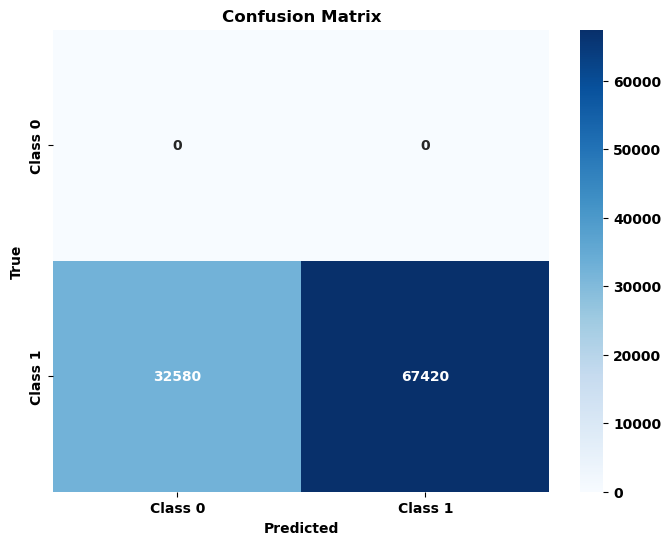

In [365]:
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(result_array, y_adsam1)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Evaluating Normal model with adversarial samples Genarated using GAN

In [2]:
modeld_ = load_model('Thesis/perfectmodel.h5')

In [353]:
modeld_.evaluate(ad_samples, result_array)

C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[89.94608039794922, 0.51694]

In [357]:
rob_classifier = KerasClassifier( model=modeld_,use_logits=False)

In [366]:
y_adsam = rob_classifier.predict(ad_samples)
y_adsam = np.round(y_adsam)
y_adsam = np.squeeze(y_adsam).astype(int)
precision = precision_score(result_array, y_adsam)
recall = recall_score(result_array, y_adsam)

print("Precision:", precision)
print("Recall:", recall)

Precision: 1.0
Recall: 0.51694


In [359]:
print(classification_report(result_array, y_adsam))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.52      0.68    100000

    accuracy                           0.52    100000
   macro avg       0.50      0.26      0.34    100000
weighted avg       1.00      0.52      0.68    100000



C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aswin\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


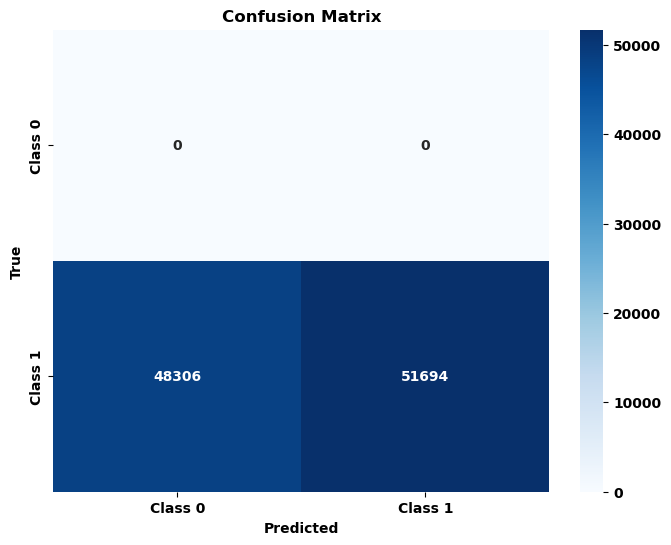

In [360]:
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(result_array, y_adsam)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [368]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [374]:
precision, recall, _ = precision_recall_curve(result_array, y_adsam)

array([1.     , 0.51694, 0.     ])

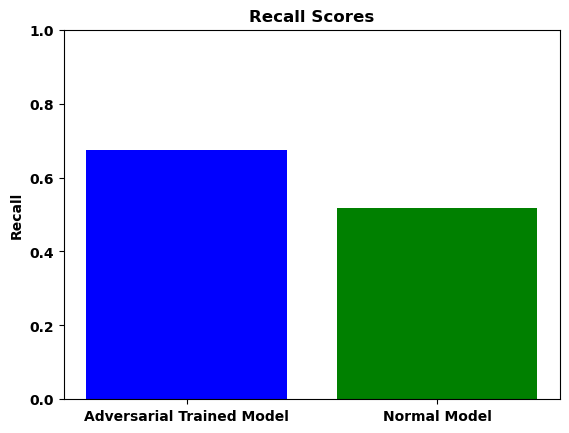

In [380]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Assuming 'y_true' contains true labels and 'y_scores_model1', 'y_scores_model2' contain predicted probabilities for the positive class.

# Compute recall scores for both models
recall_model1 = recall_score(result_array, y_adsam1)
recall_model2 = recall_score(result_array, y_adsam)

# Plot recall scores
models = [ 'Adversarial Trained Model','Normal Model']
recall_scores = [recall_model1, recall_model2]

plt.bar(models, recall_scores, color=['blue', 'green'])
plt.ylabel('Recall')
plt.title('Recall Scores')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1 for recall scores
plt.show()


In [384]:
model.save("Thesis/adTrainedmodel.h5")